In [3]:
from EnsemblePursuit.EnsemblePursuit import EnsemblePursuit
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import zscore
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from sklearn.preprocessing import MinMaxScaler

In [5]:
data_path='/media/maria/DATA1/Documents/data_for_suite2p/TX39/'
dt=1
spks= np.load(data_path+'spks.npy')
print('Shape of the data matrix, neurons by timepoints:',spks.shape)
iframe = np.load(data_path+'iframe.npy') # iframe[n] is the microscope frame for the image frame n
ivalid = iframe+dt<spks.shape[-1] # remove timepoints outside the valid time range
iframe = iframe[ivalid]
S = spks[:, iframe+dt]
print(S.shape)
U=np.load('U.npy')
del spks

Shape of the data matrix, neurons by timepoints: (18795, 30766)
(18795, 30560)


(642,)


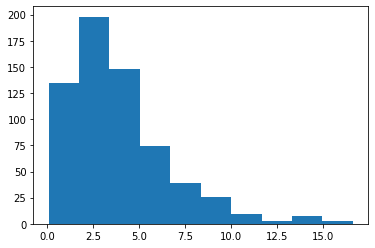

(463,)


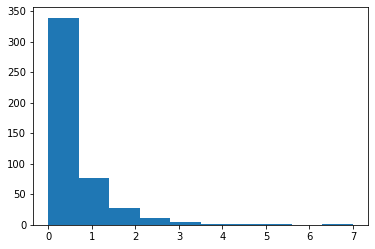

In [6]:
stim_ens_inds=np.nonzero(U[:,13])[0]
print(stim_ens_inds.shape)
stim_k=2.0
stim_theta=2.0
stim_weights=np.random.gamma(shape=stim_k,scale=stim_theta,size=(stim_ens_inds.shape[0],))
plt.hist(stim_weights)
plt.show()

beh_ens_inds=np.nonzero(U[:,8])[0]
print(beh_ens_inds.shape)
beh_k=0.5
beh_theta=1.0
beh_weights=np.random.gamma(shape=beh_k,scale=beh_theta,size=(beh_ens_inds.shape[0],))
plt.hist(beh_weights)
plt.show()

In [4]:
#stim_ens_inds=np.nonzero(U[:,13])[0].sum()

In [7]:
weights=np.hstack((stim_weights,beh_weights))
sc=MinMaxScaler()
weights=sc.fit_transform(weights.reshape(-1,1))
print(weights)

stim_inp=S[stim_ens_inds]
beh_imp=S[beh_ens_inds]
input_patterns=np.vstack((stim_inp,beh_imp))
sc=MinMaxScaler()
input_patterns=sc.fit_transform(input_patterns)

[[0.00427992]
 [0.07295347]
 [0.37443337]
 ...
 [0.01202963]
 [0.00147306]
 [0.0089608 ]]


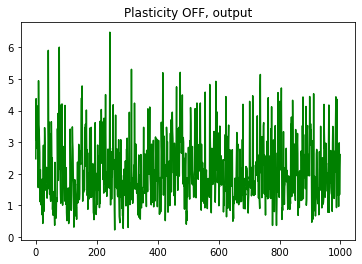

In [12]:
weights=weights.flatten()
v_lst=[np.dot(weights,input_patterns[:,0])]
for j in range(1,30560):
    v_lst.append(np.dot(weights,input_patterns[:,j]))
plt.plot(v_lst[:1000],color='g')
plt.title('Plasticity OFF, output')
plt.show()
v_lst=np.array(v_lst)

(1105,)
(1105, 30560)
[0.00427992 0.07295347 0.37443337 ... 0.01202963 0.00147306 0.0089608 ]
[-0.80430659 -0.79557076 -1.47470715 ... -0.73130974 -0.10916992
  0.36536569]
[-0.79595682 -0.78730835 -1.45965337 ... -0.72368993 -0.10777152
  0.36201874]
[-0.78581457 -0.77725258 -1.44287415 ... -0.71427035 -0.10451112
  0.36058124]
[-0.77365395 -0.76517758 -1.42414294 ... -0.70282518 -0.09916353
  0.3612779 ]
[-0.75942407 -0.75103247 -1.40340817 ... -0.68930359 -0.09167856
  0.36415845]
[-0.7414023  -0.73309462 -1.37894656 ... -0.67198302 -0.08033425
  0.3709444 ]
[-0.72142657 -0.71320195 -1.35259538 ... -0.65270148 -0.06696919
  0.37979667]
[-0.69850889 -0.69036652 -1.32336602 ... -0.63047105 -0.05059609
  0.39170211]
[-0.67235417 -0.66429323 -1.29096273 ... -0.60499671 -0.0309205
  0.40695472]
[-0.64704414 -0.6390638  -1.25946661 ... -0.58036025 -0.0120248
  0.42147167]
[-0.61530337 -0.60740284 -1.22160162 ... -0.54928632  0.01336577
  0.44252728]
[-0.57998501 -0.57216348 -1.18022027 ..

[2.38951724 2.38957407 2.38515644 ... 2.38999207 2.39403895 2.3971257 ]
[2.37871893 2.37877518 2.37440173 ... 2.37918901 2.38319542 2.3862513 ]
[2.36817871 2.36823441 2.36390469 ... 2.36864409 2.37261044 2.37563576]
[2.35730052 2.35735566 2.35306924 ... 2.35776125 2.36168793 2.364683  ]
[2.34696615 2.34702074 2.34277718 ... 2.34742227 2.35130969 2.35427481]
[2.33618487 2.33623891 2.33203779 ... 2.33663643 2.34048498 2.34342044]
[2.32719448 2.32724798 2.32308887 ... 2.32764153 2.33145158 2.3343577 ]
[2.31839038 2.31844334 2.31432582 ... 2.31883295 2.32260491 2.32548196]
[2.31313422 2.31318666 2.30911031 ... 2.31357237 2.3173066  2.32015489]
[2.31057116 2.31062307 2.30658748 ... 2.31100492 2.31470182 2.31752161]
[2.30774237 2.30779376 2.30379853 ... 2.30817179 2.31183172 2.31462332]
[2.3042165  2.30426738 2.3003121  ... 2.30464163 2.30826496 2.31102864]
[2.29961073 2.2996611  2.29574538 ... 2.30003162 2.30361871 2.30635476]
[2.295616   2.29566586 2.2917893  ... 2.29603267 2.29958389 2.30

[1.89944397 1.89944452 1.899402   ... 1.89944855 1.8994875  1.89951722]
[1.90281176 1.9028123  1.9027702  ... 1.90281628 1.90285485 1.90288427]
[1.90607913 1.90607966 1.90603798 ... 1.90608361 1.90612179 1.90615091]
[1.90874276 1.90874329 1.90870203 ... 1.9087472  1.908785   1.90881383]
[1.91165288 1.91165341 1.91161256 ... 1.91165727 1.91169469 1.91172324]
[1.91384957 1.91385009 1.91380965 ... 1.91385391 1.91389096 1.91391922]
[1.91736514 1.91736565 1.91732562 ... 1.91736944 1.91740612 1.91743409]
[1.91965526 1.91965577 1.91961613 ... 1.91965952 1.91969583 1.91972353]
[1.92033009 1.9203306  1.92029136 ... 1.92033431 1.92037026 1.92039767]
[1.91937038 1.91937088 1.91933203 ... 1.91937455 1.91941014 1.91943729]
[1.91717024 1.91717073 1.91713227 ... 1.91717437 1.9172096  1.91723648]
[1.91274741 1.9127479  1.91270983 ... 1.9127515  1.91278638 1.91281299]
[1.9102814  1.91028188 1.91024419 ... 1.91028545 1.91031998 1.91034632]
[1.9118177  1.91181818 1.91178087 ... 1.91182171 1.9118559  1.91

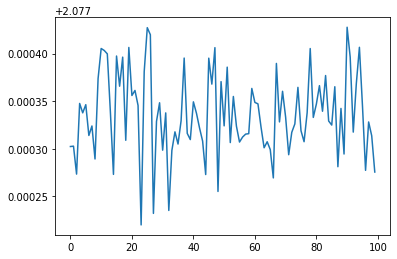

[2.07730238 2.07730276 2.07727344 ... 2.07730553 2.07733239 2.07735288]


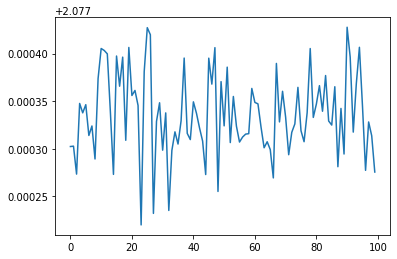

[2.07730238 2.07730276 2.07727344 ... 2.07730553 2.07733239 2.07735288]


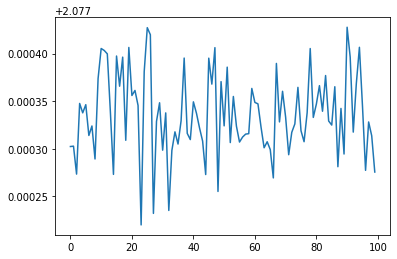

[2.07730238 2.07730276 2.07727344 ... 2.07730553 2.07733239 2.07735288]


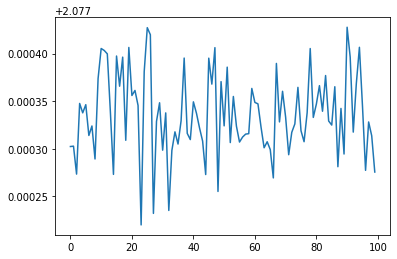

[2.07730238 2.07730276 2.07727344 ... 2.07730553 2.07733239 2.07735288]


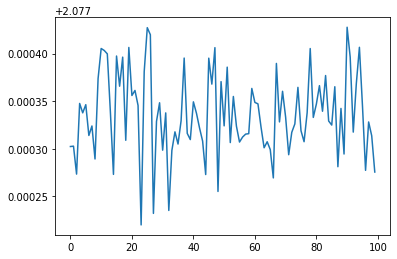

In [13]:
def gain_function(x):
        #x=np.array(x)
        #x[x<0]= 5*np.tanh(x[x<0]/5)
        r_0=0.5
        r_max=10.0
        #print(x)
        
        #if x>0:
            #return r_0*np.tanh(x/r_0)
        #else:
            #return (r_max-r_0)*np.tanh(x/(r_max-r_0))
        
        #x[x>=0]=(4000-5)*np.tanh(x[x>=0]/(4000-5))
        return x
    
def update_weights(pre_syn_activity_pattern,post_syn_activity_pattern,W,theta_BCM):
    alpha = 0.01
    #print('syn',pre_syn_activity_pattern.reshape(9479,1)@post_syn_activity_pattern.reshape(1,2))
    W+= alpha*pre_syn_activity_pattern.reshape(1105,)*post_syn_activity_pattern.reshape(1,)*(post_syn_activity_pattern-theta_BCM)
    W[W<0]=0
    return W
def update_BCM_threshold(theta_BCM,activity_pattern):
    theta_BCM_dt = 0.01
    BCM_target = 2.0
    tau_theta=0.1
    #print(theta_BCM)
    theta_BCM += theta_BCM_dt*(((activity_pattern/BCM_target)*activity_pattern - theta_BCM))
    print(theta_BCM)
    return theta_BCM

activity_patterns=input_patterns
theta_lst=[]
print(weights.shape)
print(activity_patterns.shape)
print(weights)
_weights=weights.flatten()
theta_BCM = np.random.normal(size=(1105,))
print(theta_BCM)
rate=np.array([[0]])
h=0.1
for t in range(0,1000):
    inpt=np.dot(_weights,activity_patterns[:,t])
    #print('inp',inpt)
    dxdt=(-rate[-1]+gain_function(inpt))
    #print('dxdt',dxdt)
    rate=np.vstack((rate,(rate[-1]+h*dxdt)))
    _weights=update_weights(activity_patterns[:,t],rate[-1],_weights,theta_BCM)
    theta_BCM=update_BCM_threshold(theta_BCM,rate[-1])
    theta_lst.append(theta_BCM)
    
#plt.plot(theta_lst)
#print(theta_BCM)
#print(theta_lst[0])
for j in range(0,5):
    plt.plot(theta_lst[j][:100])
    print(theta_lst[j])
    plt.show()

Text(0.5, 1.0, 'BCM Plasticity ON, output')

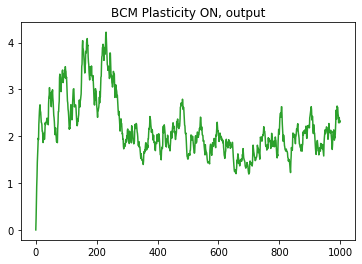

In [18]:
plt.plot(rate,color='tab:green')
plt.title('BCM Plasticity ON, output')

In [11]:
v_lst=rate[1:10001].flatten()
def train_test_split(NT):
        nsegs = 20
        nt=NT
        nlen  = nt/nsegs
        ninds = np.linspace(0,nt-nlen,nsegs).astype(int)
        itest = (ninds[:,np.newaxis] + np.arange(0,nlen*0.25,1,int)).flatten()
        itrain = np.ones(nt, np.bool)
        itrain[itest] = 0
        return itrain, itest

mov=np.load(data_path+'mov.npy')
mov = mov[:, :, ivalid]
ly, lx, nstim = mov.shape
#print(nstim)
NT = v_lst.shape[0]
NN=1
mov=mov[:,:,:NT]
print(NT)
itrain,itest=train_test_split(NT)

X = np.reshape(mov, [-1, NT]) # reshape to Npixels by Ntimepoints
X = X-0.5 # subtract the background
X = np.abs(X) # does not matter if a pixel is black (0) or white (1)
X = zscore(X, axis=1)/NT**.5  # z-score each pixel separately
npix = X.shape[0]

lam = 0.1
#ncomps = Sp.shape[0]
B0 = np.linalg.solve((X[:,itrain] @ X[:,itrain].T + lam * np.eye(npix)),  (X[:,itrain] @ v_lst[itrain].T)) # get the receptive fields for each neuron

B0 = np.reshape(B0, (ly, lx, 1))
B0 = gaussian_filter(B0, [.5, .5, 0])

1000


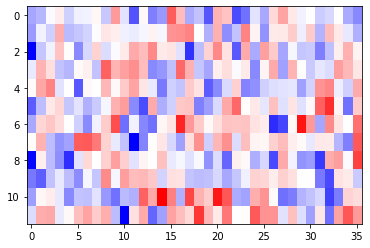

In [12]:

rf = B0[:,:,0]
rfmax = np.max(B0)
# rfmax = np.max(np.abs(rf))
plt.imshow(rf, aspect='auto', cmap = 'bwr', vmin = -rfmax, vmax = rfmax)